In [1]:
%load_ext autoreload
%autoreload 2

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [2]:
# # Define experiment settings
# numEach = 5
# trainingEpochs = 100
# learningRate = 5e-2
# dropoutSetting = 0.5
# weightDecaySetting = learningRate * 1e-1
# verbose = False
# useNet = 'MLP4'
# richInfo = True

# runExperiment = False
# saveResults = False

# if runExperiment:
#     # Saving Parameters
#     saveDir=Path('../data/alignmentShaping')
#     if not os.path.exists(saveDir): os.makedirs(saveDir)

#     # Run experiment
#     pDropout = np.repeat([0,0,dropoutSetting],numEach)
#     weightDecay = np.repeat([0,weightDecaySetting,0],numEach)
#     fullResults = nnexp.compareAlignmentDropout(useNet=useNet,DEVICE=DEVICE,iterations=trainingEpochs,learningRate=learningRate,pDropout=pDropout,weightDecay=weightDecay,verbose=verbose,richInfo=richInfo)

#     if saveResults:
#         fileName = f'alignmentShaping_{useNet}_{date.today()}.pkl'
#         with open(saveDir / fileName, 'wb') as f:
#             pickle.dump(fullResults, f)

In [ ]:
# # Load results from previous run
# useNet = 'MLP4'
# # fileNames = glob(f"../data/networkComparisonDropoutRegular/networkComparison_{useNet}_*.pkl")
# fileNames = glob(f"../data/networkComparisonDropoutRegularRichInfo/networkComparison_{useNet}_*07.pkl")
# NF = len(fileNames)
# if NF>1: raise ValueError("Didn't prepare for this")

# with open(fileNames[0],'rb') as f:
#     fullResults = pickle.load(f)
    
# pDropout = np.array([fr['pDropout'] for fr in fullResults])
# weightDecay = np.array([fr['cWeightDecay'] for fr in fullResults])

In [2]:
def hardCutoff(fractionVariance,cutoff):
    # Only keep eigenvectors with an eigenvalue that exceeds some criterion
    return np.where(fractionVariance>=cutoff,1.,0.)    

In [5]:
# Define experiment settings
useNet = 'MLP4'
iterations = 25
learningRate = 5e-2
verbose = False

# First, select device to run networks on
if DEVICE is None: DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"
print(f"Initiating experiment using {DEVICE}")

# Experiment Parameters
numEach = 3
weightDecaySetting = 1e-3
doManual = np.repeat([True,True,True,False],numEach)
evCutoff = np.repeat([0.01,0.001,0.0001,0],numEach)
pDropout = 0

# Prepare Network and Preprocessing
batchSize = 500
if useNet=='CNN2P2':
    convActivation = F.relu
    linearActivation = F.relu
    net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
    ])
elif useNet=='MLP4':
    actFunc = F.relu
    net = models.MLP4(actFunc=actFunc,pDropout=pDropout)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        transforms.Lambda(torch.flatten), # convert to vectors
    ])
else:
    raise ValueError('useNet not recognized')

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

# Prepare Training Functions 
lossFunction = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

fullResults = []

# Train Networks without dropout
numRuns = len(doManual)
for runidx, prms in enumerate(zip(doManual,evCutoff)):
    cDoManual, cEvCutoff = prms
    
    t = time.time()

    # Create new network
    if useNet=='CNN2P2':
        net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)
        net.to(DEVICE)
    elif useNet=='MLP4':
        net = models.MLP4(actFunc=actFunc,pDropout=pDropout)
        net.to(DEVICE)
    else: 
        raise ValueError("useNet not recognized")
    
    # Set up optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=learningRate, weight_decay=weightDecaySetting)
    # optimizer = torch.optim.Adadelta(net.parameters(), weight_decay=cWeightDecay)

    # Train network (richInfo switch measures the eigenfeatures at every epoch of training)
    results = nnutils.trainNetworkManualShape(net, trainloader, lossFunction, optimizer, iterations, DEVICE, verbose=verbose, doManual=cDoManual, evalTransform=lambda x: hardCutoff(x, cEvCutoff))

    # remove dropout and then measuring test performance
    storeDropout = results['net'].getDropout()
    results['net'].setDropout(0)
    results['trainloader'] = trainloader
    results['testloader'] = testloader
    results['manualShape'] = cDoManual
    results['pDropout'] = 0
    results['weightDecay'] = weightDecaySetting
    results['evCutoff'] = cEvCutoff
    testLoss, testAccuracy = nnutils.measurePerformance(results['net'], testloader, DEVICE=DEVICE, verbose=False)
    print(f"Network {runidx+1}/{numRuns} finished in {time.time()-t:.1f} seconds. doManual:{cDoManual:.1f}. WeightDecay:{weightDecaySetting}. Test loss:{testLoss:.2f}. Test accuracy: {testAccuracy:.2f}%.")
    results['net'].setDropout(storeDropout)

    # Save Everything, delete unnecessary, continue
    fullResults.append(results)
    del net, results

Initiating experiment using cuda
Network 1/12 finished in 143.0 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.18. Test accuracy: 94.35%.
Network 2/12 finished in 137.4 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.16. Test accuracy: 94.74%.
Network 3/12 finished in 137.5 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.19. Test accuracy: 94.09%.
Network 4/12 finished in 138.8 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.11. Test accuracy: 96.78%.
Network 5/12 finished in 143.1 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.11. Test accuracy: 96.65%.
Network 6/12 finished in 137.5 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.11. Test accuracy: 96.50%.
Network 7/12 finished in 142.4 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.09. Test accuracy: 97.31%.
Network 8/12 finished in 137.0 seconds. doManual:1.0. WeightDecay:0.001. Test loss:0.09. Test accuracy: 97.20%.
Network 9/12 finished in 138.3 seconds. doManual:1.0. WeightDecay:0.001

In [6]:
numRuns = len(fullResults)
numLayers = len(fullResults[0]['alignFull'][0])
alignFull = [res['alignFull'] for res in fullResults]
alignMean = torch.stack([res['net'].avgFromFull(res['alignFull']) for res in fullResults])
alignLayer = [[] for _ in range(numLayers)]
for layer in tqdm(range(numLayers)):
    # First put each layers alignment trajectory as a list in alignLayer
    for runidx in range(numRuns):
        alignLayer[layer].append(fullResults[runidx]['net'].layerFromFull(alignFull[runidx],layer))
    # Then concatenate across them all, so we have a (numRuns, numNodes, numEpochs) tensor describing alignment trajectory
    alignLayer[layer] = torch.stack(alignLayer[layer])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


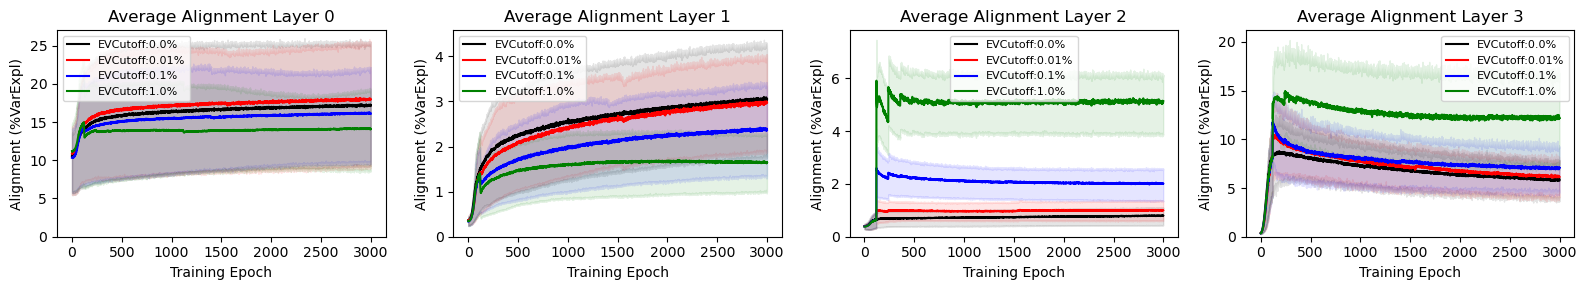

In [7]:
expTypes,idxTypes = np.unique(evCutoff,return_inverse=True)
NET = len(expTypes)
numEpoch = alignLayer[0].shape[2]

qRange = (0.2,0.8)
cols = 'krbg'

fig, ax = plt.subplots(1,numLayers,figsize=(16,3))
for layer in range(numLayers):
    for eidx in range(NET):
        cidx = idxTypes==eidx
        cmn = 100*torch.mean(alignMean[cidx,layer,:],dim=0)
        cse = 100*torch.std(alignMean[cidx,layer,:],dim=0)
        uq = 100*torch.mean(torch.quantile(alignLayer[layer][cidx,:,:],q=qRange[1],dim=1),dim=0)
        lq = 100*torch.mean(torch.quantile(alignLayer[layer][cidx,:,:],q=qRange[0],dim=1),dim=0)
        ax[layer].plot(range(numEpoch), cmn, c=cols[eidx], linewidth=1.5, label=f'EVCutoff:{100*expTypes[eidx]}%')
        ax[layer].fill_between(range(numEpoch), uq, lq, color=cols[eidx], alpha=0.1)
    
    # Labels
    ax[layer].set_ylim(0)
    ax[layer].set_xlabel('Training Epoch')
    ax[layer].set_ylabel('Alignment (%VarExpl)')
    ax[layer].set_title(f'Average Alignment Layer {layer}')
    ax[layer].legend(fontsize=8,loc='best')
    
plt.tight_layout()

In [11]:
# Test adversarial examples

# FGSM attack code
fgsm_transform = lambda x : x #(0.3081 * (x - torch.mean(x,dim=1,keepdim=True))/torch.std(x,dim=1,keepdim=True)) + 0.1307

def fgsm_attack(image, epsilon, data_grad, transform):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign() #.clone() #.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = transform(perturbed_image)
    # Return the perturbed image
    return perturbed_image

def test( model, device, test_loader, epsilon ):
    
    NE = len(epsilon)
    allAccuracy = torch.zeros(NE)
    allExamples = [[] for _ in range(NE)]
    allNewAccuracy = torch.zeros(NE)
    
    # Loss function
    lossFunction = nn.CrossEntropyLoss()

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = torch.argmax(output,axis=1) # find true prediction
        leastLikely = torch.argmin(output,axis=1) # find least likely digit according to model
        
        # Calculate the loss
        loss = lossFunction(output, target) # calculate loss as if it was supposed to be the least likely digit

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
        
        for epsidx, eps in enumerate(epsilon):
            
            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, eps, data_grad, fgsm_transform)

            # Re-classify the perturbed image
            output = model(perturbed_data)

            # Check for success
            final_pred = torch.argmax(output,axis=1)
            allAccuracy[epsidx] += sum(final_pred==target).cpu()
            allNewAccuracy[epsidx] += sum(final_pred==leastLikely).cpu()
            
            # Idx where adversarial example worked
            idxSuccessfulAttack = torch.where(torch.logical_and(init_pred==target,final_pred!=target))[0].cpu()
            adv_ex = perturbed_data.detach().cpu().numpy()
            allExamples[epsidx].append((init_pred[idxSuccessfulAttack],final_pred[idxSuccessfulAttack],adv_ex[idxSuccessfulAttack]))

    # Calculate final accuracy for this epsilon
    for i in range(NE):
        allAccuracy[i] = allAccuracy[i]/float(len(test_loader.dataset))
        allNewAccuracy[i] = allNewAccuracy[i]/float(len(test_loader.dataset))
        
    # Return the accuracy and an adversarial example
    return allAccuracy, allNewAccuracy, allExamples

In [12]:
epsilons = np.linspace(0,1,31)
#epsilons = np.hstack((0, np.logspace(2,4,5)))
# epsilons = np.hstack((0, np.linspace(100,6000,21)))
NE = len(epsilons)

prtAccuracy = torch.zeros((NE,numRuns))
newAccuracy = torch.zeros((NE,numRuns))
# accuracies = []
# examples = []

# Run test for each epsilon
for runidx in tqdm(range(numRuns)):
    acc, newacc, ex = test(fullResults[runidx]['net'], DEVICE, fullResults[runidx]['testloader'], epsilons)
    for epsidx in range(NE):
        prtAccuracy[epsidx,runidx] = acc[epsidx]
        newAccuracy[epsidx,runidx] = newacc[epsidx]

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.13s/it]


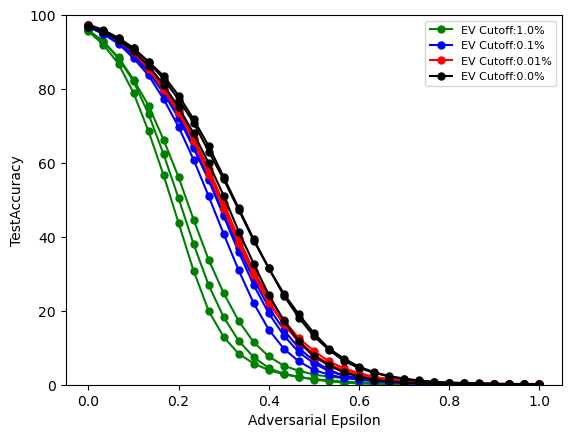

In [13]:
evCuts, evcidx = np.unique(evCutoff, return_index=True)

cols = 'krbg'
cdict = dict(zip(evCuts,np.arange(len(evCuts))))
glabel = np.zeros(len(np.unique(evCutoff)))
for runidx in range(numRuns):
    ccol = cols[cdict[evCutoff[runidx]]]
    label = f'EV Cutoff:{100*evCutoff[runidx]}%' if np.any(evcidx==runidx) else None
    plt.plot(epsilons, 100*prtAccuracy[:,runidx], c=ccol, label=label, marker='.', markersize=10);
# plt.xticks(epsilons,np.round(epsilons));
plt.ylim(0,100)
plt.legend(loc='best',fontsize=8)
plt.xlabel('Adversarial Epsilon')
plt.ylabel('TestAccuracy');

In [358]:
torch.cov(torch.normal(0,1,(50,10))).shape

torch.Size([50, 50])

In [363]:
nw = fullResults[runidx]['net'].getNetworkWeights()[2:]
len(nw)

2